In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  %cd /content/drive/MyDrive/M6_Project/week2
  !ls

Mounted at /content/drive
/content/drive/MyDrive/M6_Project/week2
ai_challenge_s03_c010-full_annotation.xml  task1.ipynb
algorithms				   task2.ipynb
background_remover.py			   task3.ipynb
eval_utils.py				   VehicleDetection.py
load_utils.py				   videoBoundingBox_MOG.gif
M6_Week2.gslides			   video_utils.py
__pycache__


In [3]:
data_path = '../datasets/AICity_data/train/S03/c010/'

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from PIL import Image
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

In [5]:
def drawRectangleOnImage(img, boxes, color=(0, 255, 0)):
    for box in boxes:
        img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 3)
    return img

## GIFs

In [6]:
def generate_gif(videoPath, fgbg, videoName='video'):
    fig, ax = plt.subplots()
    plt.axis('off')
    
    vidcap = cv2.VideoCapture(videoPath)
    ims = []
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    for frame in tqdm(range(1,num_frames//4)):
        for i in range(4):
            _, image = vidcap.read()
        fgmask = fgbg.apply(image)
        
        im = ax.imshow(fgmask, animated=True)
        ims.append([im])
    # break

    ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=10000)
    ani.save(videoName + ".gif", writer=animation.PillowWriter(fps=24))

In [26]:
def generate_BB_comparison(videoPath, gt, predicted, videoName='videoBoundingBox'):
    fig, ax = plt.subplots()
    plt.axis('off')

    vidcap = cv2.VideoCapture(videoPath)
    ims = []
    green = (0,255,0)
    red = (255,0,0)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    for frame in tqdm(range(1,num_frames//4)):
        for i in range(4):
            _, image = vidcap.read()
        frame = frame*4
        if str(frame) in gt:
            image = drawBoxes(image, gt[str(frame)], green)

            if str(frame) in predicted:
                image = drawBoxes(image, predicted[str(frame)], red)
        im = ax.imshow(image, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=10000)
    ani.save(videoName + ".gif", writer=animation.PillowWriter(fps=24))

## Background estimation

In [29]:
def closing(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def opening(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)

def gaussianBlur(mask, kernel_w=3, kernel_h=3):
    return cv2.GaussianBlur(mask, (kernel_w,kernel_h),0)

def remove_background3(videoPath, ROIpath, fgbg):
    roi = cv2.imread(ROIpath, cv2.IMREAD_GRAYSCALE)
    
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    # num_frames = 1000
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:

            # image = cv2.medianBlur(image, 7)
            fgmask = fgbg.apply(image)
            fgmask[fgmask==127]=0 # remove shadows
            
            roi_applied = cv2.bitwise_and(fgmask, roi)
            cleaned = opening(roi_applied, 5, 5) #initial removal of small noise
            cleaned = closing(cleaned, 50, 20) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            cleaned = closing(cleaned, 20, 50) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            cleaned = opening(cleaned, 7, 7) #final removal of noise

            roi_applied = cv2.bitwise_and(cleaned, roi)

            # cv2.imwrite(f'./masks/mask_{frame}.png', roi_applied)

            detections[str(frame)] = getBoxesFromMask(cleaned)
    return detections

In [20]:
### GT without parked cars
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')
gt_notParked = getNotParkedCars(gt_detect)

In [21]:
mog = cv2.bgsegm.createBackgroundSubtractorMOG()
mog2 = cv2.createBackgroundSubtractorMOG2()
knn = cv2.createBackgroundSubtractorKNN()
gmg = cv2.bgsegm.createBackgroundSubtractorGMG()

### MOG

100%|██████████| 2141/2141 [02:51<00:00, 12.48it/s]


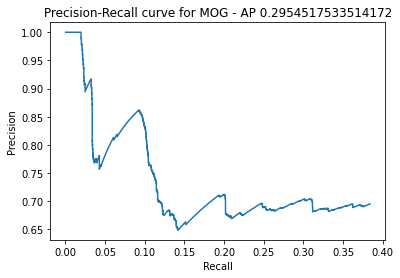

In [30]:
MOG_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', mog)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, MOG_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for MOG - AP {ap}')

100%|██████████| 534/534 [00:45<00:00, 11.66it/s]


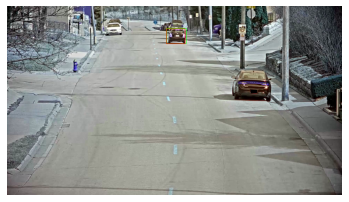

In [31]:
generate_BB_comparison(data_path + 'vdo.avi', gt_notParked, MOG_detections, videoName='videoBoundingBox_MOG')

In [14]:
# generate_videoBB_comparison(data_path + 'vdo.avi', gt_notParked, MOG_detections, videoName='videoBoundingBox_MOG', initialFrame=500, lastFrame=1000)

### MOG2

100%|██████████| 2141/2141 [03:13<00:00, 11.04it/s]


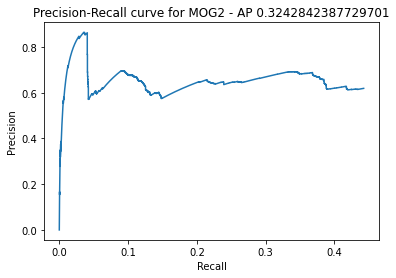

In [32]:
MOG2_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', mog2)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, MOG2_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for MOG2 - AP {ap}')

100%|██████████| 534/534 [00:41<00:00, 12.73it/s]


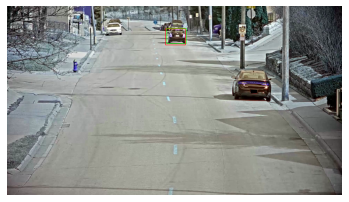

In [33]:
generate_BB_comparison(data_path + 'vdo.avi', gt_notParked, MOG2_detections, videoName='videoBoundingBox_MOG2')

### KNN

100%|██████████| 2141/2141 [03:21<00:00, 10.62it/s]


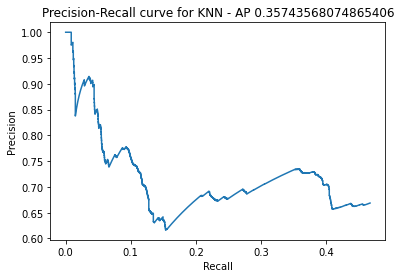

In [34]:
KNN_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', knn)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, KNN_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for KNN - AP {ap}')

100%|██████████| 534/534 [00:40<00:00, 13.33it/s]


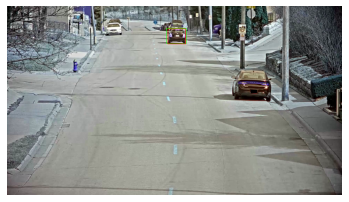

In [35]:
generate_BB_comparison(data_path + 'vdo.avi', gt_notParked, KNN_detections, videoName='videoBoundingBox_KNN')

### GMG

100%|██████████| 2141/2141 [06:31<00:00,  5.47it/s]


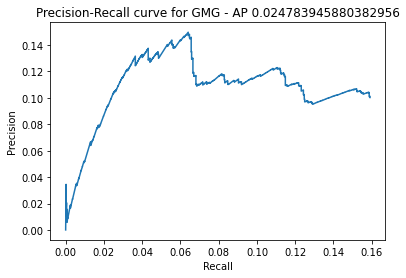

In [36]:
GMG_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', gmg)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, GMG_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for GMG - AP {ap}')

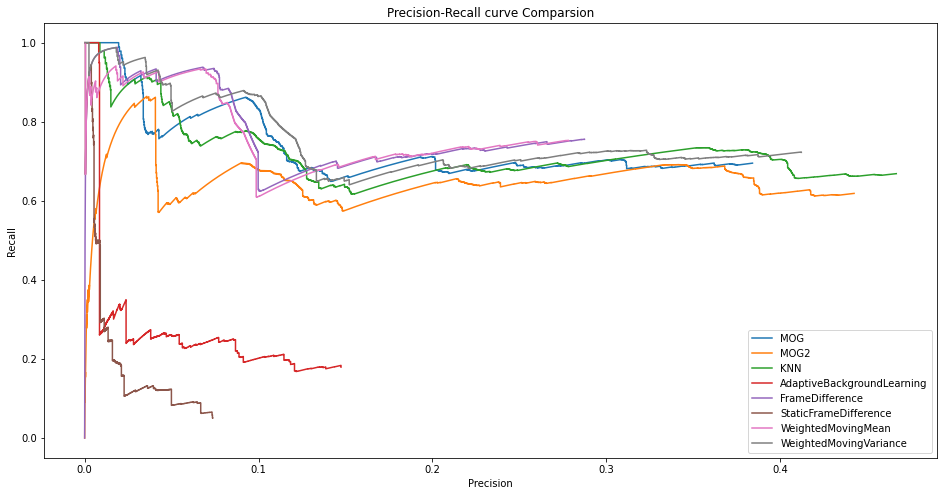

In [44]:
plt.figure(figsize=(16,8)) 
rec, prec, _, _, _, _ = voc_eval(gt_notParked, MOG_detections, 0.5, False)
# plotting the points
plt.plot(rec, prec, label = "MOG")

rec, prec, _, _, _, _ = voc_eval(gt_notParked, MOG2_detections, 0.5, False)
# plotting the points
plt.plot(rec, prec, label = "MOG2")

rec, prec, _, _, _, _ = voc_eval(gt_notParked, KNN_detections, 0.5, False)
# plotting the points
plt.plot(rec, prec, label = "KNN")

prec, rec = np.load('algorithms/AdaptiveBackgroundLearning.npy')
plt.plot(rec, prec, label = "AdaptiveBackgroundLearning")

prec, rec = np.load('algorithms/FrameDifference.npy')
plt.plot(rec, prec, label = "FrameDifference")

prec, rec = np.load('algorithms/StaticFrameDifference.npy')
plt.plot(rec, prec, label = "StaticFrameDifference")

prec, rec = np.load('algorithms/WeightedMovingMean.npy')
plt.plot(rec, prec, label = "WeightedMovingMean")

prec, rec = np.load('algorithms/WeightedMovingVariance.npy')
plt.plot(rec, prec, label = "WeightedMovingVariance")

# naming the x axis
plt.xlabel("Precision")
# naming the y axis
plt.ylabel("Recall")

# giving a title to my graph
plt.title("Precision-Recall curve Comparsion")
plt.legend()

# function to show the plot
plt.show()